## What data does transitous have?

In [21]:
import os
import json

# List all JSON files in the specified directory
json_files = [
    f for f in os.listdir("../../data/transitous/feeds/") if f.endswith(".json")
]
# format is "{country_code}.json"
countries = [f.split(".")[0] for f in json_files]

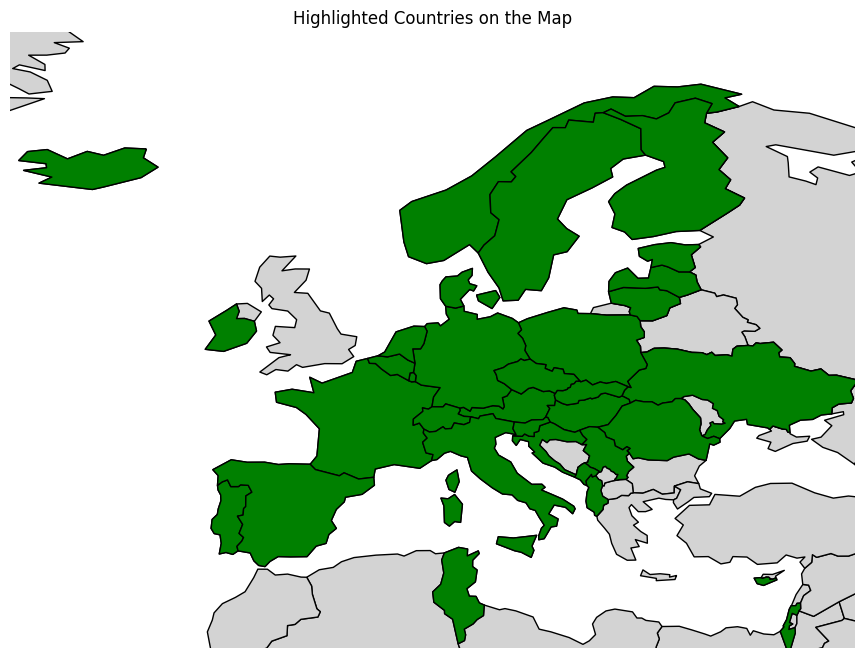

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
from iso3166 import countries as iso_countries


def plot_countries(country_codes, show_eu_only=False):
    world = gpd.read_file(
        "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    )
    country_codes = [code.lower() for code in country_codes]

    selected_countries = []
    for code in country_codes:
        if code.startswith("us-"):
            selected_countries.append("United States")
        elif code.startswith("ca-"):
            selected_countries.append("Canada")
        elif code == "eu":
            selected_countries.append("European Union")
        else:
            try:
                selected_countries.append(iso_countries.get(code.upper()).name)
            except KeyError:
                print(f"Warning: Country code {code} not recognized")

    world["highlight"] = world["NAME"].isin(selected_countries)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    world.plot(ax=ax, color="lightgray", edgecolor="black")
    world[world["highlight"]].plot(ax=ax, color="green", edgecolor="black")
    if show_eu_only:
        # zoom in on Europe
        ax.set_xlim(-25, 40)
        ax.set_ylim(30, 75)
    ax.set_axis_off()
    plt.title("Highlighted Countries on the Map")
    plt.show()


# Example usage
plot_countries(countries, show_eu_only=True)

In [23]:
COUNTRIES = ['CH', 'FR', 'DE', 'BE', 'ES', 'IT', 'AD', 'GB', 'NL', 'AT', 'LU',
    'PT', 'PL', 'RU', 'BY', 'HU', 'CZ', 'SK', 'HR', 'DK', 'SE', 'SI',
    'MA', 'IE', 'BG', 'GR', 'LT', 'LV', 'MK', 'NO', 'RO', 'UA', 'TR',
    'RS', 'ME', 'BA', 'FI', 'LI', 'AL', 'MT', 'MD', 'EE', 'CY']
for json_file in json_files:
    if json_file.split(".")[0].upper() in COUNTRIES:
        data = json.load(open(f"../../data/transitous/feeds/{json_file}"))
        for source in data['sources']:
            if source['type'] == 'url':
                pass

## What are the different sources of URLs?

In [24]:
import pandas as pd

feed_urls_path = "../../scripts/download/feed_urls.csv"
url_downloads_path = "../../scripts/download/url_download.csv"
gtfs_data_info_path = "../../scripts/process_gtfs/gtfs_file_info.csv"
transitous_transitland_path = "../../scripts/download/transitland_ids.txt"

feed_urls = pd.read_csv(feed_urls_path)
url_downloads = pd.read_csv(url_downloads_path)
gtfs_data_info = pd.read_csv(gtfs_data_info_path)
with open(transitous_transitland_path, "r") as file:
    transitous_transitland = [line.strip() for line in file]

In [25]:
# Find the most recent date for source "transitous"
most_recent_date = feed_urls[feed_urls['source'] == 'transitous']['time_added'].max()

# Find all rows where transitous_transitland matches source_id
matching_rows = feed_urls[feed_urls['id'].isin(transitous_transitland)]

# Create new rows with the same date and source "transitous"
new_rows = matching_rows.copy()
new_rows['source'] = 'transitous'
new_rows['time_added'] = most_recent_date

# Append the new rows to the dataframe
feed_urls = pd.concat([feed_urls, new_rows], ignore_index=True)

In [26]:
import re
import os

feed_urls = feed_urls.sort_values('time_added').drop_duplicates(subset=['url', 'source'], keep='last')

gtfs_data_info = gtfs_data_info.sort_values("date").drop_duplicates(subset="filename", keep="last")

url_downloads["file_path"] = url_downloads["file_path"].apply(lambda x: os.path.basename(x))
# Define a function to clean the status column
def clean_status(status):
    if "IncompleteRead" in status:
        return "error: IncompleteRead: connection closed"
    if "ConnectionResetError" in status:
        return "error: ConnectionResetError: connection closed"
    match = re.match(r"(error: [a-zA-Z]+)\([^)]*\): ([\w ]*)", status)
    if match:
        return f"{match.group(1)}: {match.group(2)}"
    return status


# Apply the function to the status column
url_downloads["status"] = url_downloads["status"].apply(clean_status)


# Merge url_downloads on file_path and filename, and only keep the "corrupted_file" column from gtfs_data_info
url_downloads = pd.merge(url_downloads, gtfs_data_info[["filename", "corrupted_file"]], left_on="file_path", right_on="filename", how="left")

# Drop the "filename" column as it is no longer needed
url_downloads = url_downloads.drop(columns=["filename"])

# Combine feed_urls with url_downloads on url value, taking the latest value in url_downloads
url_downloads_latest = url_downloads.sort_values("end_time").drop_duplicates(
    subset="url", keep="last"
)
feed_urls = pd.merge(
    feed_urls, url_downloads_latest[["url", "status", "corrupted_file", "file_path"]], on="url", how="left"
)

feed_urls["status"] = feed_urls["status"].apply(lambda x: x == "200" or x == "ftp")
feed_urls["status"] = feed_urls["status"].apply(lambda x: "Valid file" if x else "Failed Download")
feed_urls["status"] = feed_urls.apply(
    lambda row: "corrupted" if row["corrupted_file"] == "True" else ("corrupted (fixed)" if row["corrupted_file"] == "fixed" else row["status"]),
    axis=1
)

In [27]:
from datetime import date

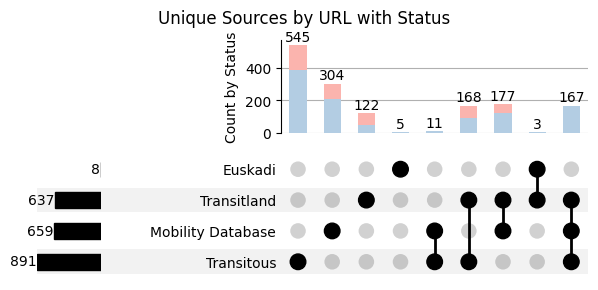

In [ ]:
import matplotlib.pyplot as plt
from upsetplot import from_contents, UpSet
from matplotlib import cm

df_grouped = feed_urls.copy()
df_grouped['status'] = df_grouped['status'].apply(lambda x: 'Valid file' if x == 'Valid file' else 'Failed download')

df_grouped = df_grouped.groupby("url").agg({
    "source": lambda x: list(set(x)),  # Get unique sources for each URL
    "status": "first"  # Assuming status is the same for duplicate URLs
}).reset_index()

# Dynamically create binary indicator columns for each unique source
sources = sorted(feed_urls["source"].unique())  # Keep sources in sorted order
for source in sources:
    df_grouped[source] = df_grouped["source"].apply(lambda x: source in x)
name_to_nice = {
    "euskadi": "Euskadi",
    "transitland": "Transitland",
    "mobilitydatabase": "Mobility Database",
    "transitous": "Transitous",
}
# Rename the sources using the name_to_nice mapping
df_grouped.rename(columns=name_to_nice, inplace=True)
sources = [name_to_nice[source] for source in sources]

# Set the dynamically created source columns as the index
df_upset = df_grouped.set_index(sources)

# Create the UpSet plot without default bars
upset = UpSet(df_upset, intersection_plot_elements=0, show_counts=True)

# Add stacked bars by "status"
upset.add_stacked_bars(by="status", colors=cm.Pastel1, title="Count by Status")

# Plot
upset.plot()
plt.suptitle("Unique Sources by URL with Status")
plt.gcf().axes[2].axis("off")
# disable legend
plt.gca().get_legend().remove()
plt.savefig(f'figures/{date.today()}_upsetplot.png')
plt.show()


In [29]:
# total number of unique urls
print(f"Total number of unique URLs: {len(df_grouped.url.unique())}")

Total number of unique URLs: 1502


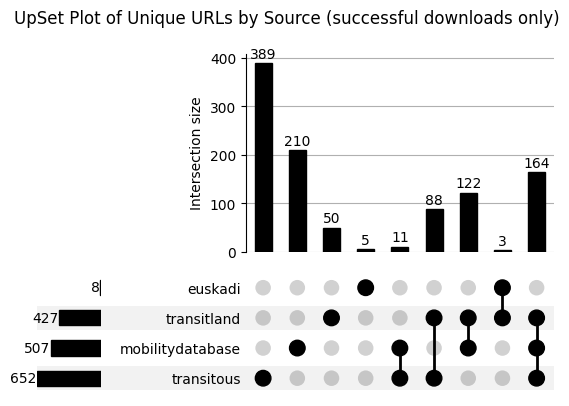

In [ ]:
import warnings
warnings.filterwarnings("ignore")
valid_feed_urls = feed_urls[feed_urls['status'] == 'Valid file']

contents = {
    source: set(valid_feed_urls[valid_feed_urls["source"] == source]["url"])
    for source in valid_feed_urls["source"].unique()
}

# Convert to an UpSet-compatible format
upset_data = from_contents(contents).infer_objects()

# Create and display the UpSet plot
upset = UpSet(upset_data, subset_size="count", show_counts=True)
upset.plot()
plt.suptitle("UpSet Plot of Unique URLs by Source (successful downloads only)")
plt.gcf().axes[2].axis("off")
plt.show()

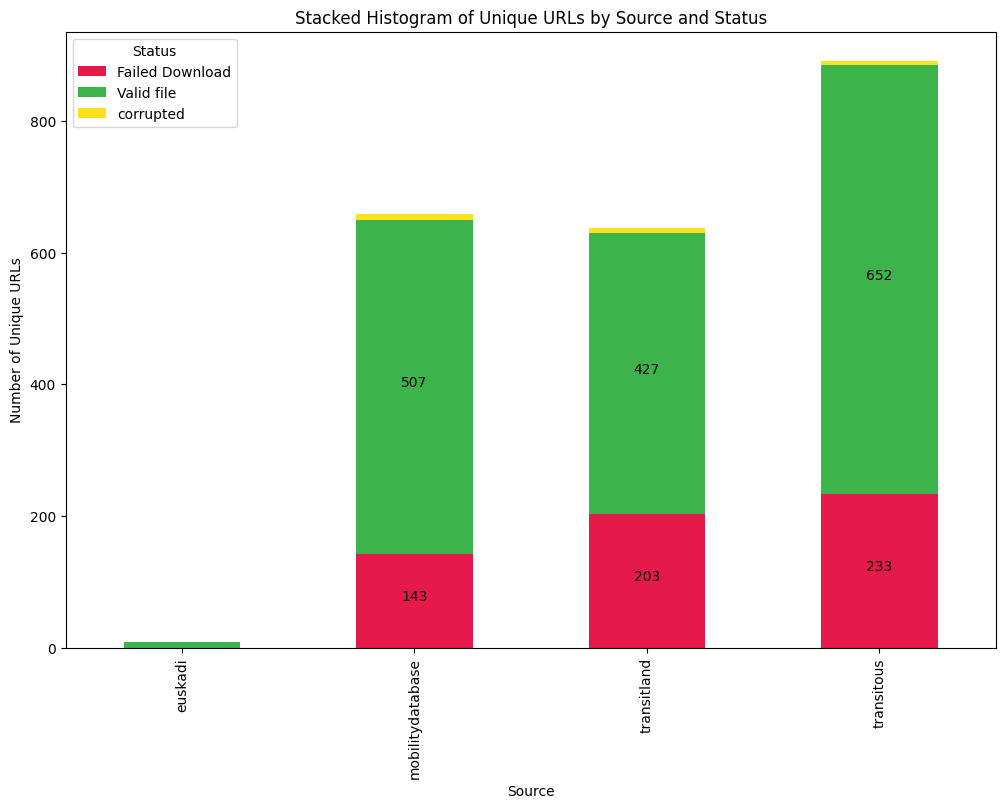

In [31]:
import matplotlib.pyplot as plt

# Use xkcd style
# plt.xkcd()

# Set the font family to a commonly available font
plt.rcParams['font.family'] = 'DejaVu Sans'

# Create a pivot table to count the number of unique URLs for each source and status
pivot_table = feed_urls.pivot_table(index='source', columns='status', values='url', aggfunc='nunique', fill_value=0)

# Define a custom color palette
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8']

# Plot the stacked histogram
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)

# Add the number of elements on each bar
for container in ax.containers:
    labels = [f'{int(val)}' if val > 10 else '' for val in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', padding=3)

plt.xlabel('Source')
plt.ylabel('Number of Unique URLs')
plt.title('Stacked Histogram of Unique URLs by Source and Status')
plt.legend(title='Status')
plt.savefig(f'figures/{date.today()}_unique_urls_by_source_and_status.png')
plt.show()

In [32]:
# Merge gtfs_data_info with feed_urls to add the "country" column
gtfs_data_info = pd.merge(gtfs_data_info, feed_urls[['file_path', 'country']], right_on='file_path', left_on='filename', how='left')

## What are the start and end dates of these files

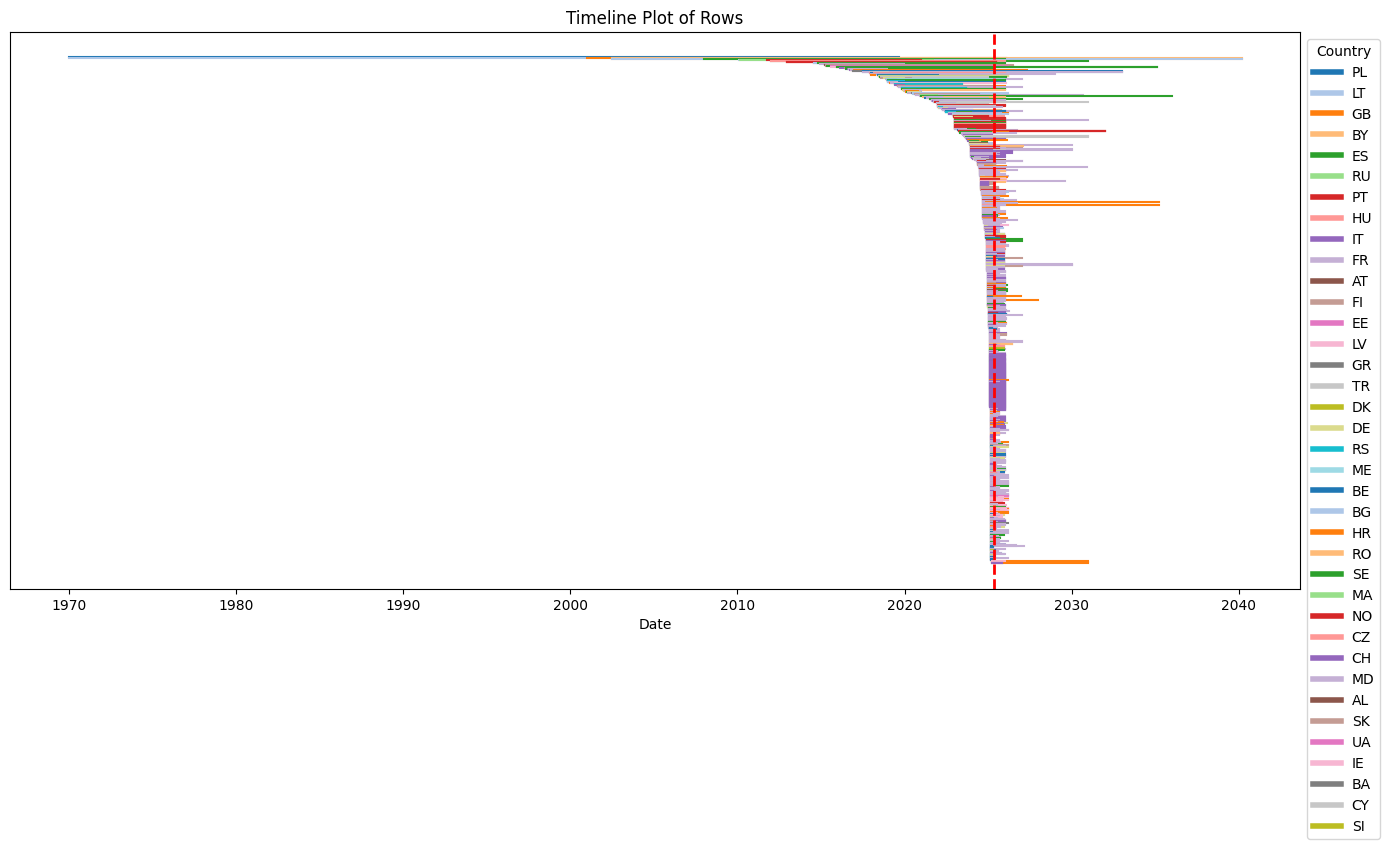

In [33]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the DataFrame by start_date and filter out rows with NaT values
df = gtfs_data_info.dropna(subset=['start_date', 'end_date']).sort_values('start_date').reset_index(drop=True)
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# Prepare the plot
plt.figure(figsize=(14, 8))

# Define a color palette
colors = sns.color_palette('tab20', len(df['country'].unique()))
color_mapping = {country: color for country, color in zip(df['country'].unique(), colors)}

# Customizing the plot
plt.yticks(range(len(df)), [f'Row {i+1}' for i in range(len(df))], fontsize=10)
plt.gca().invert_yaxis()  # Optional: Invert to have earliest rows at the top
plt.xlabel('Date')
plt.title('Timeline Plot of Rows')
# Instead of just clearing the labels, remove the y-ticks entirely:
plt.gca().set_yticks([])


# Plot the data
for i, row in df.iterrows():
    start_date = pd.to_datetime(row['start_date'])
    end_date = pd.to_datetime(row['end_date'])
    country = row['country']
    color = color_mapping.get(country, 'black')
    
    # if start_date == end_date:
    #     plt.plot(start_date, i, 'o', color=color)  # Draw a point
    # else:
    plt.plot([start_date, end_date], [i, i], '-', color=color)  # Draw a line

# Add a vertical line on today's date
today = datetime.datetime.today()
plt.axvline(today, color='red', linestyle='--', linewidth=2, label="Today's Date")
# Add a legend with country names
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_mapping.values()]
labels = ['Unknown' if str(label) == 'nan' else label for label in color_mapping.keys()]
plt.legend(handles, labels, title="Country", loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout()
plt.savefig(f'figures/{date.today()}_timeline_plot.png')
plt.show()

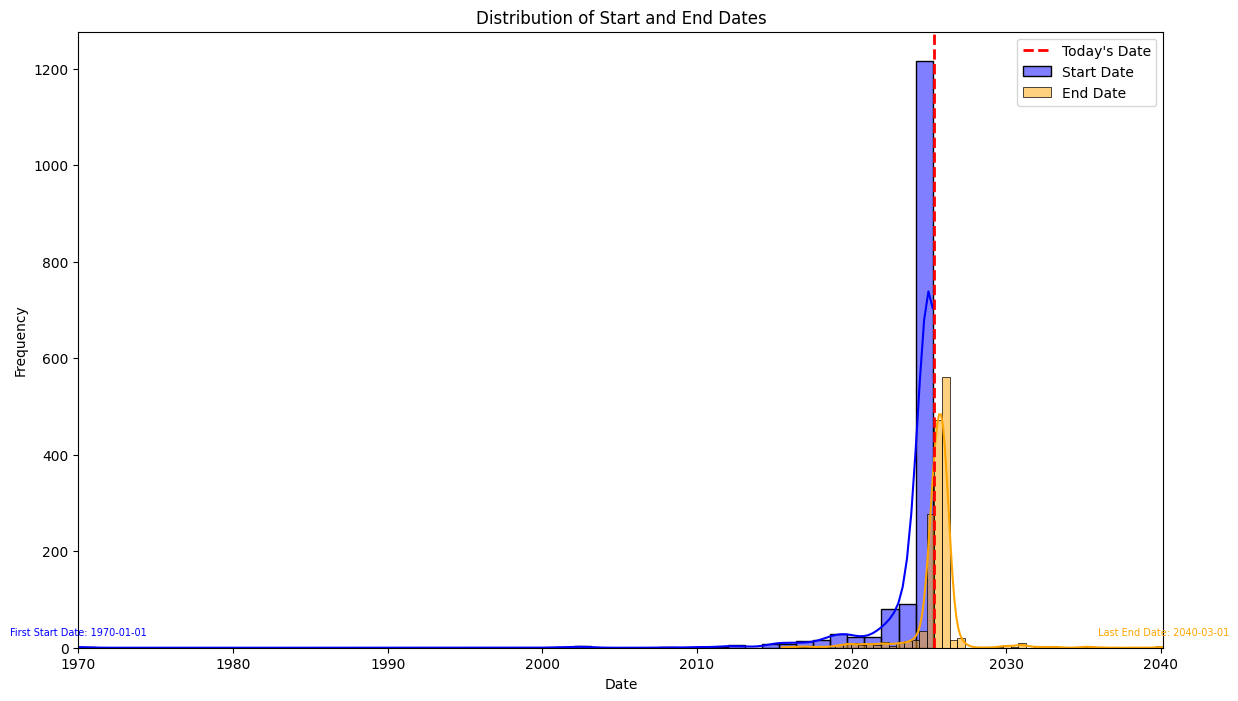

In [34]:
# Prepare your DataFrame
plt.figure(figsize=(14, 8))

# Plot histograms for start and end dates
sns.histplot(df['start_date'], bins=50, color='blue', label='Start Date', kde=True, alpha=0.5)
sns.histplot(df['end_date'], bins=50, color='orange', label='End Date', kde=True, alpha=0.5)

# Add a vertical line for today's date
today = datetime.datetime.today()
plt.axvline(today, color='red', linestyle='--', linewidth=2, label="Today's Date")

# Add text labels for the first start date and last end date
first_start_date = df['start_date'].min()
last_end_date = df['end_date'].max()
plt.text(first_start_date, plt.ylim()[1] * 0.02, f'First Start Date: {first_start_date.date()}', color='blue', fontsize=7, ha='center')
plt.text(last_end_date, plt.ylim()[1] * 0.02, f'Last End Date: {last_end_date.date()}', color='orange', fontsize=7, ha='center')

# Set the x-axis limits to start at the first start date and end at the last end date
plt.xlim(first_start_date, last_end_date)

plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Start and End Dates')
plt.legend()
plt.savefig(f'figures/{date.today()}_start_end_date_distribution.png')
plt.show()


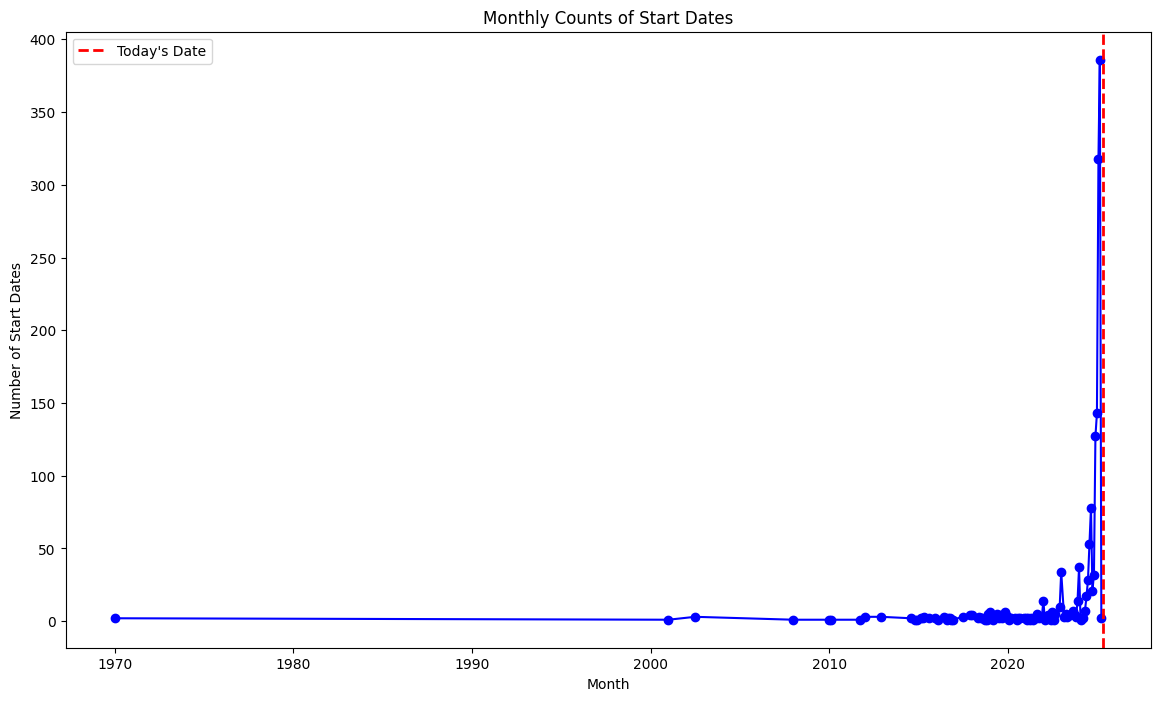

In [35]:
df['start_month'] = df['start_date'].dt.to_period('M').dt.to_timestamp()
monthly_counts = df.groupby('start_month').size()

plt.figure(figsize=(14, 8))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color='blue')
plt.xlabel('Month')
plt.ylabel('Number of Start Dates')
plt.title('Monthly Counts of Start Dates')
plt.axvline(today, color='red', linestyle='--', linewidth=2, label="Today's Date")
plt.legend()
plt.savefig(f'figures/{date.today()}_monthly_counts.png')
plt.show()

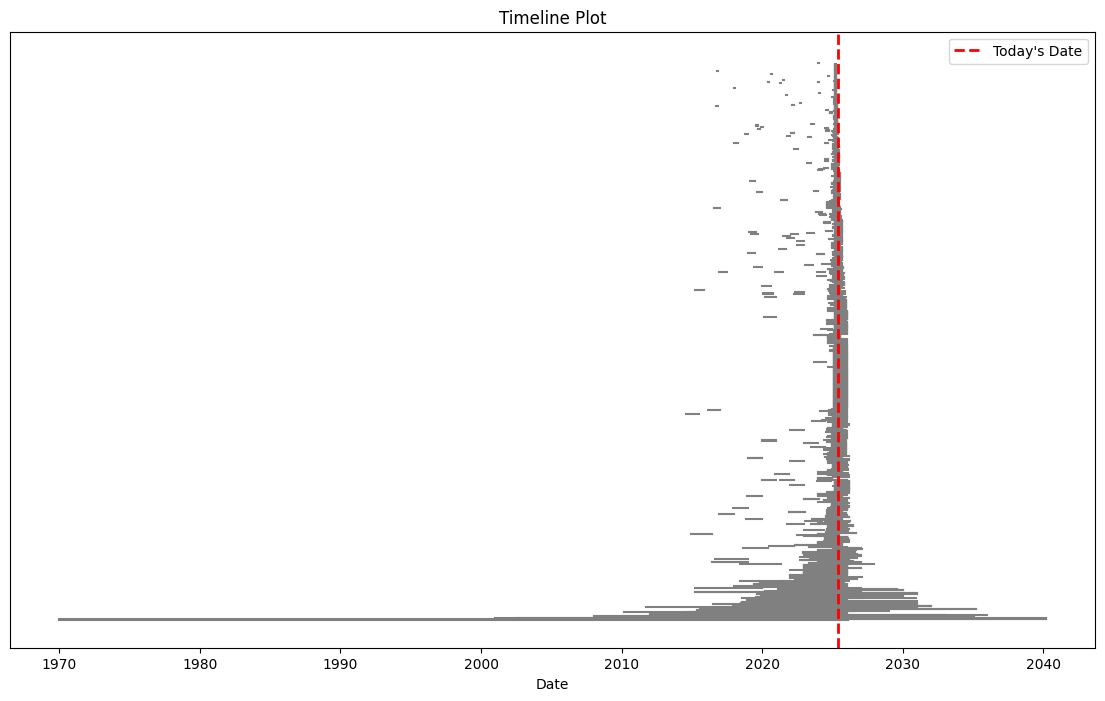

In [36]:
df['duration'] = df['end_date'] - df['start_date']
df = df.sort_values(by='duration', ascending=False, ignore_index=True)
plt.figure(figsize=(14, 8))

for i, row in df.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    plt.plot([start_date, end_date], [i, i], '-', color='gray')

# Add today's date line
plt.axvline(today, color='red', linestyle='--', linewidth=2, label="Today's Date")

plt.xlabel('Date')
plt.title('Timeline Plot')
plt.gca().set_yticks([])  # Remove y-ticks for clarity
plt.legend()
plt.savefig(f'figures/{date.today()}_timeline_plot.png')
plt.show()

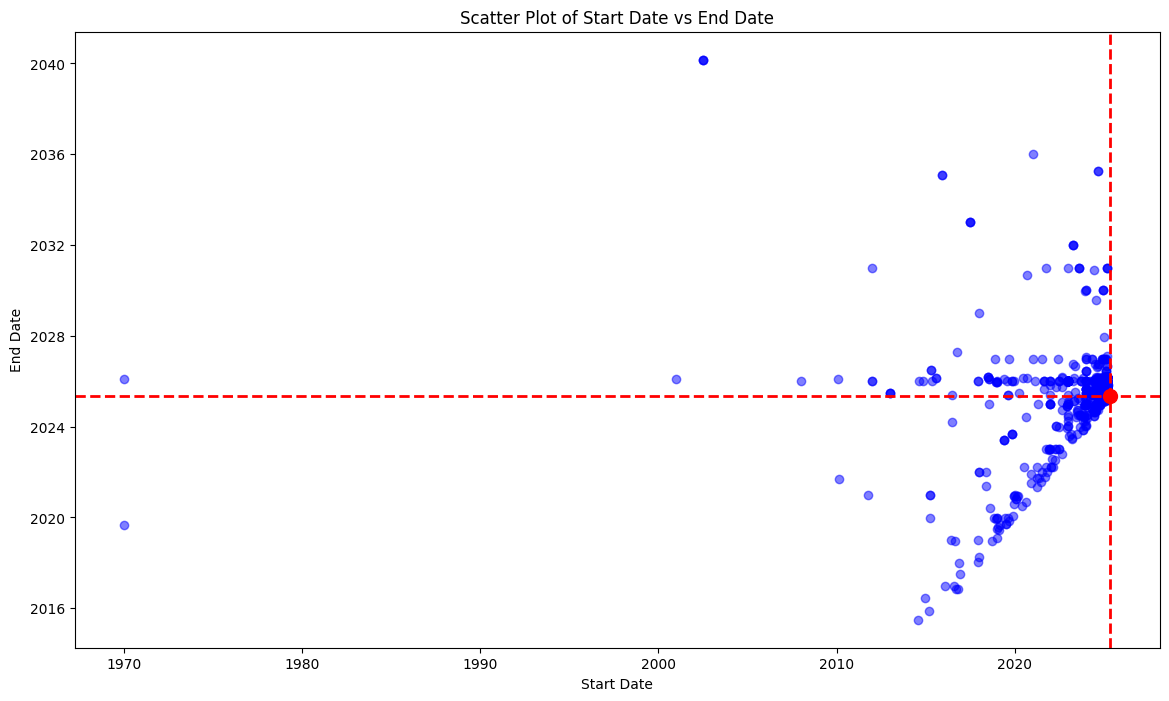

In [37]:
plt.figure(figsize=(14, 8))

# Create a scatter plot
plt.scatter(df['start_date'], df['end_date'], alpha=0.5, c='blue')

# Add labels and title
plt.xlabel('Start Date')
plt.ylabel('End Date')
plt.title('Scatter Plot of Start Date vs End Date')

# Add a red dot for today's date
plt.scatter(today, today, color='red', s=100, label="Today's Date")
# draw a rectangle of all parts with start_date > today and end_date < today
plt.axvline(today, color='red', linestyle='--', linewidth=2, label="Today's Date")
plt.axhline(today, color='red', linestyle='--', linewidth=2, label="Today's Date")
plt.savefig(f'figures/{date.today()}_scatter_plot.png')
plt.show()

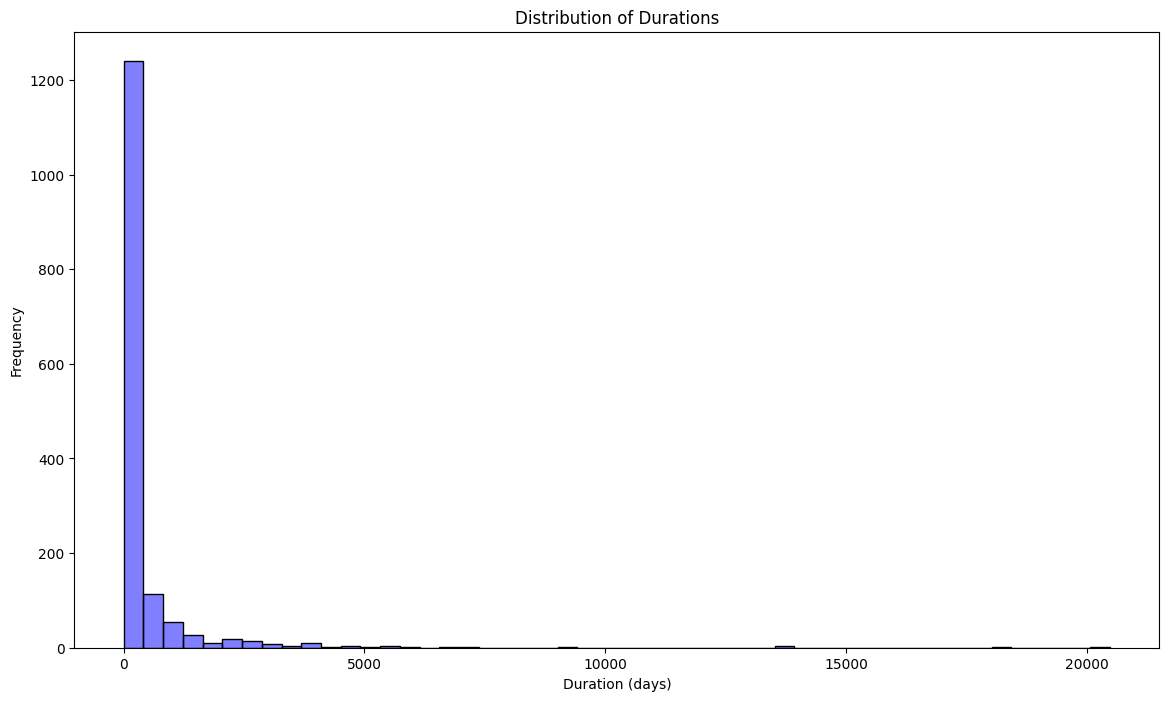

In [38]:
plt.figure(figsize=(14, 8))

# Plot histogram of duration
sns.histplot(df['duration'].dt.days, bins=50, color='blue', alpha=0.5)

plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Durations')
plt.savefig(f'figures/{date.today()}_duration_distribution.png')
plt.show()

## What route types are there?

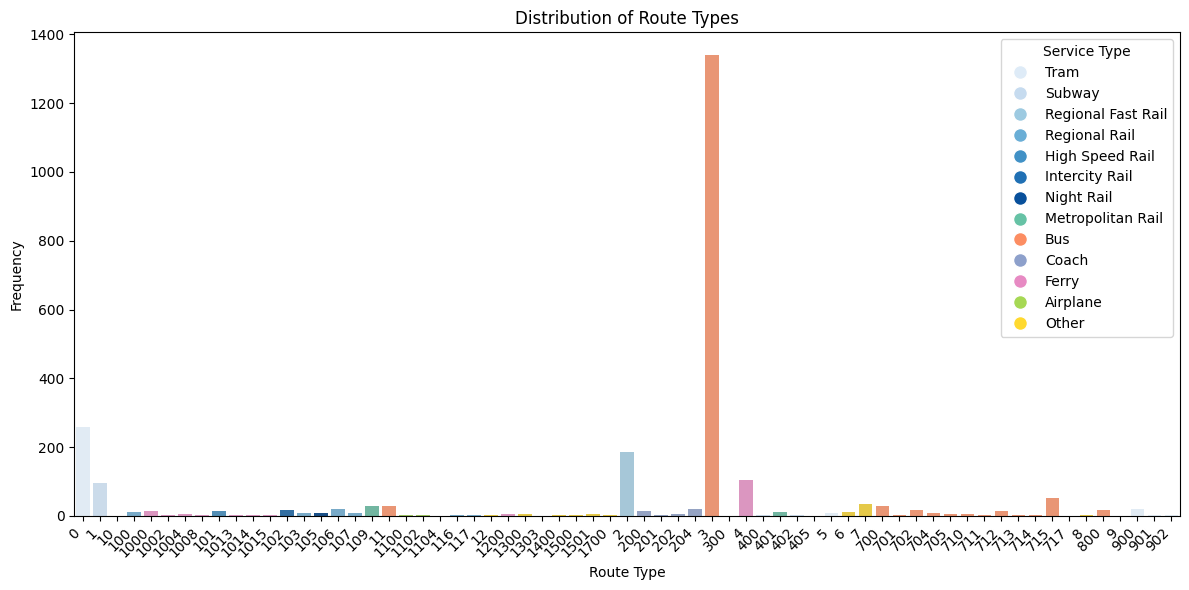

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define a compact mapping from service type to list of route type codes.
service_codes = {
    'Tram': [0, 5, 900, 901, 902, 903, 904, 905, 906],
    'Subway': [1, 400, 402],
    'Regional Fast Rail': [2],
    'Regional Rail': [100, 103, 106, 107, 108, 110, 111, 112, 113, 115, 116, 117],
    'High Speed Rail': [101],
    'Intercity Rail': [102, 104, 114],
    'Night Rail': [105],
    'Metropolitan Rail': [109, 401, 403, 404, 405],
    'Bus': [3, 11, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 800],
    'Coach': [200, 201, 202, 203, 204, 205, 206, 207, 208, 209],
    'Ferry': [4, 1000, 1200],
    'Airplane': [1100],
    'Other': [6, 7, 12, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307,
              1400, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1700, 1702]
}

def get_service_type(rt):
    for service, codes in service_codes.items():
        if rt in codes:
            return service
    # Additional range checks for unmapped values:
    if 1000 <= rt < 1100:
        return 'Ferry'
    if 1100 <= rt < 1200:
        return 'Airplane'
    if 1200 <= rt < 1300:
        return 'Ferry'
    return 'Other'

# Process the dataframe: drop rows missing route_types and convert each to a list of ints.
df = gtfs_data_info.dropna(subset=['route_types']).copy()
df['route_types'] = df['route_types'].str.split(',').apply(lambda rts: [int(rt) for rt in rts if rt])

# Count occurrences of each route type.
counts = pd.Series([rt for rts in df['route_types'] for rt in rts]).value_counts()

# Map each numeric route type (as a string) to its service type.
service_labels = {str(rt): get_service_type(rt) for rt in counts.index}

# Define desired service order and associated colors.
service_order = [
    'Tram', 'Subway', 'Regional Fast Rail', 'Regional Rail', 'High Speed Rail',
    'Intercity Rail', 'Night Rail', 'Metropolitan Rail', 'Bus', 'Coach',
    'Ferry', 'Airplane', 'Other'
]

# Define a custom color palette
rail_colors = sns.color_palette("Blues", 7)  # Different shades of blue for rail categories
other_colors = sns.color_palette("Set2", len(service_order) - 7)  # Different colors for other categories
palette = rail_colors + other_colors
color_mapping = {s: c for s, c in zip(service_order, palette)}

# Convert index to strings and sort lexicographically.
counts = counts.rename(index=str).sort_index(key=lambda x: x.astype(str))
colors = [color_mapping[service_labels[rt]] for rt in counts.index]

plt.figure(figsize=(12, 6))
sns.barplot(x=counts.index, y=counts.values, palette=colors)
plt.title('Distribution of Route Types')
plt.xlabel('Route Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

# Create a legend mapping service names to colors.
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[s],
               markersize=10, label=s)
    for s in service_order
]
plt.legend(title='Service Type', handles=handles)

plt.tight_layout()
plt.savefig(f'figures/{date.today()}_route_type_distribution.png')
plt.show()

## What are the bboxes of these gtfs files?

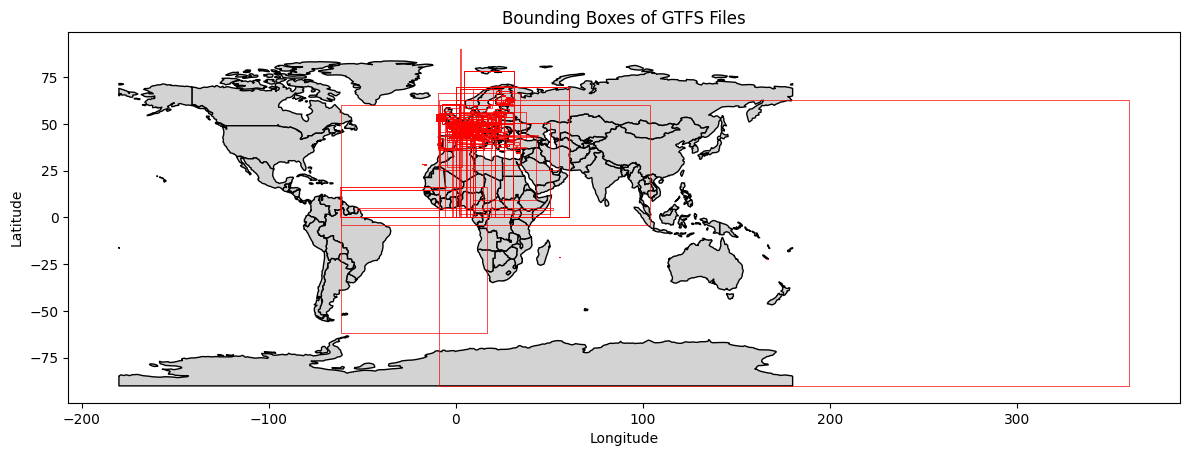

In [40]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# Convert bbox column to lists of floats
df = gtfs_data_info.dropna(subset=['bbox'])
df['bbox'] = df['bbox'].apply(lambda bbox: [float(x) for x in bbox.split(',')])

# Filter out rows with bbox containing inf or -inf values
valid_bboxes = df[df['bbox'].apply(lambda bbox: all(-float('inf') < x < float('inf') for x in bbox))]

# Create a GeoDataFrame to store the bounding boxes
gdf = gpd.GeoDataFrame(valid_bboxes, geometry=valid_bboxes['bbox'].apply(lambda bbox: box(bbox[1], bbox[0], bbox[3], bbox[2])), crs="EPSG:4326")

# Plot the bounding boxes on a map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
world.plot(ax=ax, color='lightgray', edgecolor='black')
gdf.boundary.plot(ax=ax, color='red', linewidth=0.5)  # Adjust the linewidth here

plt.title('Bounding Boxes of GTFS Files')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig(f'figures/{date.today()}_bounding_boxes.png', bbox_inches='tight')
plt.show()

In [41]:
# Extract the bbox values into a list of tuples
bbox_values = df['bbox'].tolist()

# Find the minimum and maximum longitude and latitude
min_lon = min(bbox[1] for bbox in bbox_values)
max_lon = max(bbox[3] for bbox in bbox_values)
min_lat = min(bbox[0] for bbox in bbox_values)
max_lat = max(bbox[2] for bbox in bbox_values)

# Find the elements that have the min and max values
min_lon_element = next(bbox for bbox in bbox_values if bbox[1] == min_lon)
max_lon_element = next(bbox for bbox in bbox_values if bbox[3] == max_lon)
min_lat_element = next(bbox for bbox in bbox_values if bbox[0] == min_lat)
max_lat_element = next(bbox for bbox in bbox_values if bbox[2] == max_lat)

# Get the filenames of the elements
min_lon_filename = df[df['bbox'].apply(lambda x: x == min_lon_element)]['filename'].values[0]
max_lon_filename = df[df['bbox'].apply(lambda x: x == max_lon_element)]['filename'].values[0]
min_lat_filename = df[df['bbox'].apply(lambda x: x == min_lat_element)]['filename'].values[0]
max_lat_filename = df[df['bbox'].apply(lambda x: x == max_lat_element)]['filename'].values[0]
print(f"Filename with Min Longitude: {min_lon_filename}. Bbox: {df[df['filename'] == min_lon_filename]['bbox'].values[0]}")
print(f"Filename with Max Longitude: {max_lon_filename}. Bbox: {df[df['filename'] == max_lon_filename]['bbox'].values[0]}")
print(f"Filename with Min Latitude: {min_lat_filename}. Bbox: {df[df['filename'] == min_lat_filename]['bbox'].values[0]}")
print(f"Filename with Max Latitude: {max_lat_filename}. Bbox: {df[df['filename'] == max_lat_filename]['bbox'].values[0]}")

Filename with Min Longitude: 917c9837.zip. Bbox: [16.202489, -61.652008, 16.342426, -61.177185]
Filename with Max Longitude: 50f4bed3.zip. Bbox: [-90.0, -9.16873, 62.897936, 360.0]
Filename with Min Latitude: 50f4bed3.zip. Bbox: [-90.0, -9.16873, 62.897936, 360.0]
Filename with Max Latitude: d3703617.zip. Bbox: [44.28347189523681, 2.445197225380727, 90.0, 3.0000000000000004]


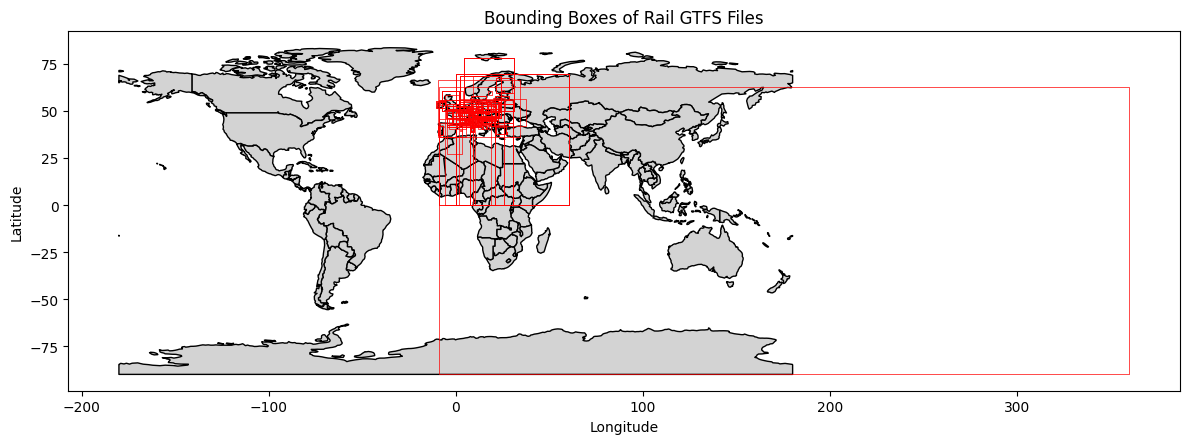

In [42]:
# Define rail types
rail_types = [2, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 400, 401, 402, 403, 404, 405]

# Filter the DataFrame to include only rows with rail types in route_types
rail_df = df[df['route_types'].apply(lambda x: any(rt.isdigit() and int(rt) in rail_types for rt in x.split(',')))]

# Convert bbox column to lists of floats
rail_df['bbox'] = rail_df['bbox'].apply(lambda bbox: [float(x) for x in bbox])

# Create a GeoDataFrame to store the bounding boxes
rail_gdf = gpd.GeoDataFrame(rail_df, geometry=rail_df['bbox'].apply(lambda bbox: box(bbox[1], bbox[0], bbox[3], bbox[2])), crs="EPSG:4326")

# Plot the bounding boxes on a map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
world.plot(ax=ax, color='lightgray', edgecolor='black')
rail_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5)  # Adjust the linewidth here

plt.title('Bounding Boxes of Rail GTFS Files')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# tight layout
plt.tight_layout()
plt.savefig(f'figures/{date.today()}_bounding_boxes_rail.png', bbox_inches='tight')
plt.show()

## What GTFS files are there?

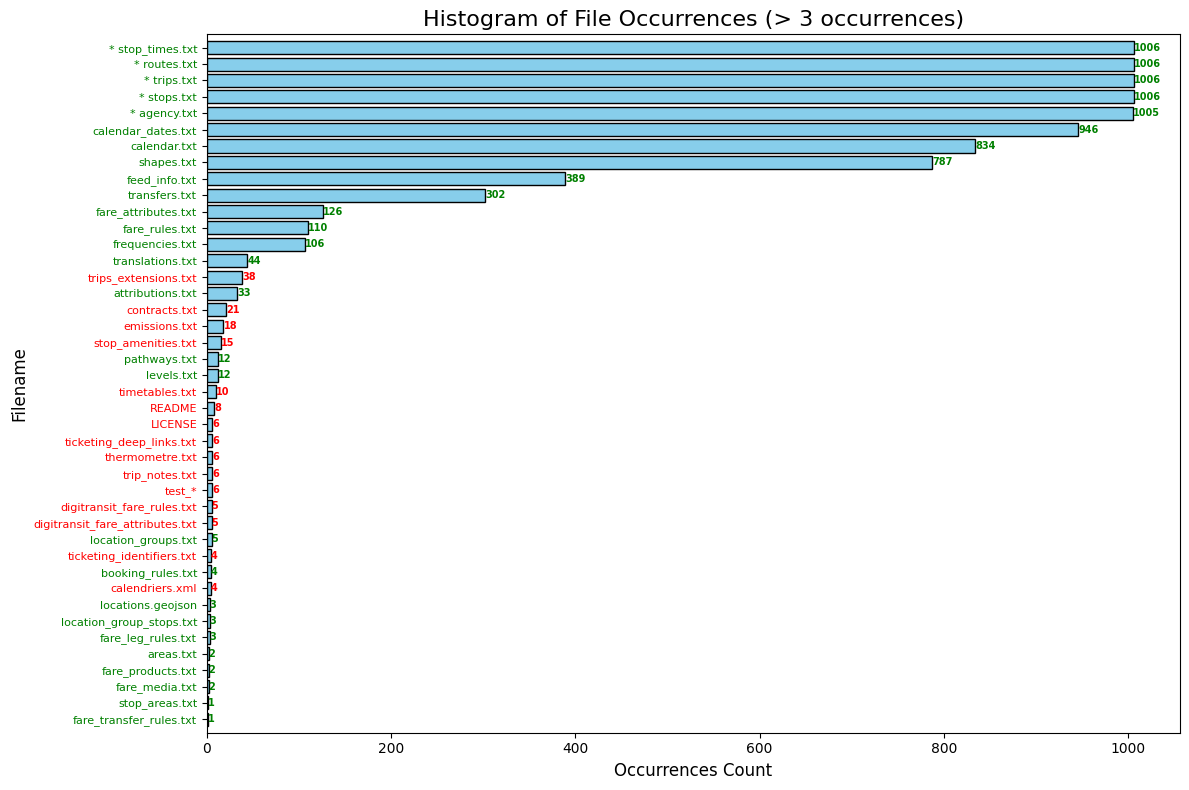

In [51]:
from collections import defaultdict
import os

# Define the official files list
official_files = [
    "agency.txt", "stops.txt", "routes.txt", "trips.txt", "stop_times.txt", "calendar.txt",
    "calendar_dates.txt", "fare_attributes.txt", "fare_rules.txt", "timeframes.txt", "fare_media.txt",
    "fare_products.txt", "fare_leg_rules.txt", "fare_transfer_rules.txt", "areas.txt", "stop_areas.txt",
    "networks.txt", "route_networks.txt", "shapes.txt", "frequencies.txt", "transfers.txt", "pathways.txt",
    "levels.txt", "location_groups.txt", "location_group_stops.txt", "locations.geojson", "booking_rules.txt",
    "translations.txt", "feed_info.txt", "attributions.txt"
]
mandatory_files = [
    "agency.txt", "routes.txt", "trips.txt", "stop_times.txt", "stops.txt",
]

# Extract file details from gtfs_data_info
file_details = []
for _, row in gtfs_data_info.dropna(subset=['gtfs_files']).iterrows():
    for file in row['gtfs_files'].split(','):
        base_name = os.path.basename(file.strip())
        if base_name.startswith("."):
            continue
        if base_name.startswith("test_"):
            base_name = "test_*"
        if "readme" in base_name.lower():
            base_name = "README"
        file_details.append({'filename': base_name, 'country': row['country']})

# Count occurrences of each filename
file_occurrences = defaultdict(list)
for entry in file_details:
    file_occurrences[entry['filename']].append(entry)

min_occurrences = 3
# Filter out filenames that are only present once and are not in official_files
filtered_file_details = [
    (filename, occurrences) for filename, occurrences in file_occurrences.items()
    if len(occurrences) > min_occurrences or filename in official_files
]
filtered_file_details = sorted(filtered_file_details, key=lambda x: len(x[1]), reverse=False)

# Prepare data for plotting
filenames = [filename for filename, _ in filtered_file_details]
occurrences_counts = [len(occurrences) for _, occurrences in filtered_file_details]

# Create the histogram
fig, ax1 = plt.subplots(figsize=(12, 8))
bars = ax1.barh(filenames, occurrences_counts, color='skyblue', edgecolor='black')
ax1.tick_params(axis='y', labelsize=8)  # Make y-axis labels smaller

# Set y-tick labels with appropriate colors and text
yticklabels = []
for i, filename in enumerate(filenames):
    label_text = '* ' + filename if filename in mandatory_files else filename
    yticklabels.append(label_text)
    label_color = 'green' if filename in official_files else 'red'
    ax1.get_yticklabels()[i].set_color(label_color)
ax1.set_yticklabels(yticklabels)

# Add labels to histogram bars
for bar, count, filename in zip(bars, occurrences_counts, filenames):
    color = 'green' if filename in official_files else 'red'
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(count),
             va='center', ha='left', color=color, fontsize=7, fontweight='bold')

ax1.set_xlabel('Occurrences Count', fontsize=12)
ax1.set_ylabel('Filename', fontsize=12)
ax1.set_title(f'Histogram of File Occurrences (> {min_occurrences} occurrences)', fontsize=16)
ax1.margins(y=0.01)
plt.tight_layout()
plt.savefig(f'figures/{date.today()}_file_occurrences.png', bbox_inches='tight')
plt.show()

In [49]:
# only keep rows in gtfs_data_info that are in the feed_urls
gtfs_data_info = gtfs_data_info[gtfs_data_info['filename'].isin(feed_urls['file_path'])]
# remove duplicates
gtfs_data_info = gtfs_data_info.drop_duplicates(subset=['filename'], keep='last')

In [ ]:
not_working = feed_urls[(feed_urls['status'] != 'Valid file') & (feed_urls['corrupted_file'].isna())]

inactive = feed_urls[feed_urls['known_status'] == 'inactive']

from duckduckgo_search import DDGS
from duckduckgo_search.exceptions import DuckDuckGoSearchException
from urllib.parse import urlparse
from tqdm import tqdm
import time

unique_inactive_netlocs = inactive['url'].apply(lambda x: urlparse(x).netloc).unique()

for netloc in tqdm(unique_inactive_netlocs, total=len(unique_inactive_netlocs)):
    # let's find all zip files on the website
    query = f"site:{netloc} filetype:zip"
    for retry in range(3):
        try:
            results = DDGS().text(query, max_results=5)
            if results:
                tqdm.write(f"Results for {netloc}: {results}")
                break
            else:
                tqdm.write(f"No results for {netloc}")
                break
        except DuckDuckGoSearchException as e:
            tqdm.write(f"Error: {e}")
            time.sleep(1)
    else:
        tqdm.write(f"Failed to get results for {netloc}")
        break


  0%|          | 0/50 [00:00<?, ?it/s]


## What's the size of files?

In [25]:
# gtfs_data_info['gtfs_files_sizes'] = gtfs_data_info['gtfs_files_sizes'].apply(lambda x: json.loads(x) if isinstance(x, str) else {})
# make sure that json acceps single quotes
gtfs_data_info['gtfs_files_sizes'] = gtfs_data_info['gtfs_files_sizes'].apply(lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else {})
gtfs_data_info['gtfs_files_sizes'] = gtfs_data_info['gtfs_files_sizes'].apply(lambda x: {k: int(v) for k, v in x.items()})

In [26]:
gtfs_data_info['gtfs_files_sizes']
total_size = gtfs_data_info['gtfs_files_sizes'].apply(lambda x: sum(x.values()) if isinstance(x, dict) else 0)
sum(total_size) / 1024 / 1024 / 1024
print(f"Total size of GTFS files: {sum(total_size) / 1024 / 1024 / 1024:.2f} GB")

Total size of GTFS files: 109.97 GB


## How many stations are there?

In [ ]:
import os
import zipfile
import csv
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from io import TextIOWrapper
from multiprocessing import Manager

# --- Main GTFS Processing Function ---

def get_locations(zip_file_path):
    all_stops = set()
    try:
        feed_prefix = os.path.splitext(os.path.basename(zip_file_path))[0]
        with zipfile.ZipFile(zip_file_path, 'r') as zf:
            with zf.open("stops.txt") as f:
                reader = csv.DictReader(TextIOWrapper(f, encoding="utf-8-sig"))
                for row in reader:
                    lat = float(row.get("stop_lat", "0"))
                    lon = float(row.get("stop_lon", "0"))
                    all_stops.add((lat, lon))
    except Exception as e:
        tqdm.write(f"Error processing {zip_file_path}: {e}")
    return all_stops

all_locations = set()
max_workers = os.cpu_count() or 1
gtfs_files = os.listdir("../../data/gtfs/downloaded_feeds_filtered")
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = [
        executor.submit(get_locations, os.path.join("../../data/gtfs/downloaded_feeds_filtered", file_path))
        for file_path in gtfs_files
    ]
    for future in tqdm(futures, desc="Processing GTFS files"):
        try:
            result = future.result()
            all_locations.update(result)
        except Exception as e:
            tqdm.write(f"Error: {e}")

Processing GTFS files: 100%|██████████| 128/128 [00:00<00:00, 499.96it/s]


In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
europe = world[world['CONTINENT'] == 'Europe']

In [29]:
country_codes = ['FR', 'CH', 'DE', 'BE', 'ES', 'IT', 'GB', 'NL', 'AT', 'LU', 'PT',
                 'PL', 'RU', 'BY', 'HU', 'CZ', 'SK', 'HR', 'DK', 'SE', 'SI', 'MA',
                 'IE', 'BG', 'GR', 'LT', 'LV', 'MK', 'NO', 'RO', 'UA', 'TR', 'RS',
                 'ME', 'BA', 'FI', 'LI', 'AL', 'MD', 'EE']

country_names = [iso_countries.get(code).name for code in country_codes]
print(country_names)

['France', 'Switzerland', 'Germany', 'Belgium', 'Spain', 'Italy', 'United Kingdom of Great Britain and Northern Ireland', 'Netherlands', 'Austria', 'Luxembourg', 'Portugal', 'Poland', 'Russian Federation', 'Belarus', 'Hungary', 'Czechia', 'Slovakia', 'Croatia', 'Denmark', 'Sweden', 'Slovenia', 'Morocco', 'Ireland', 'Bulgaria', 'Greece', 'Lithuania', 'Latvia', 'North Macedonia', 'Norway', 'Romania', 'Ukraine', 'Türkiye', 'Serbia', 'Montenegro', 'Bosnia and Herzegovina', 'Finland', 'Liechtenstein', 'Albania', 'Moldova, Republic of', 'Estonia']


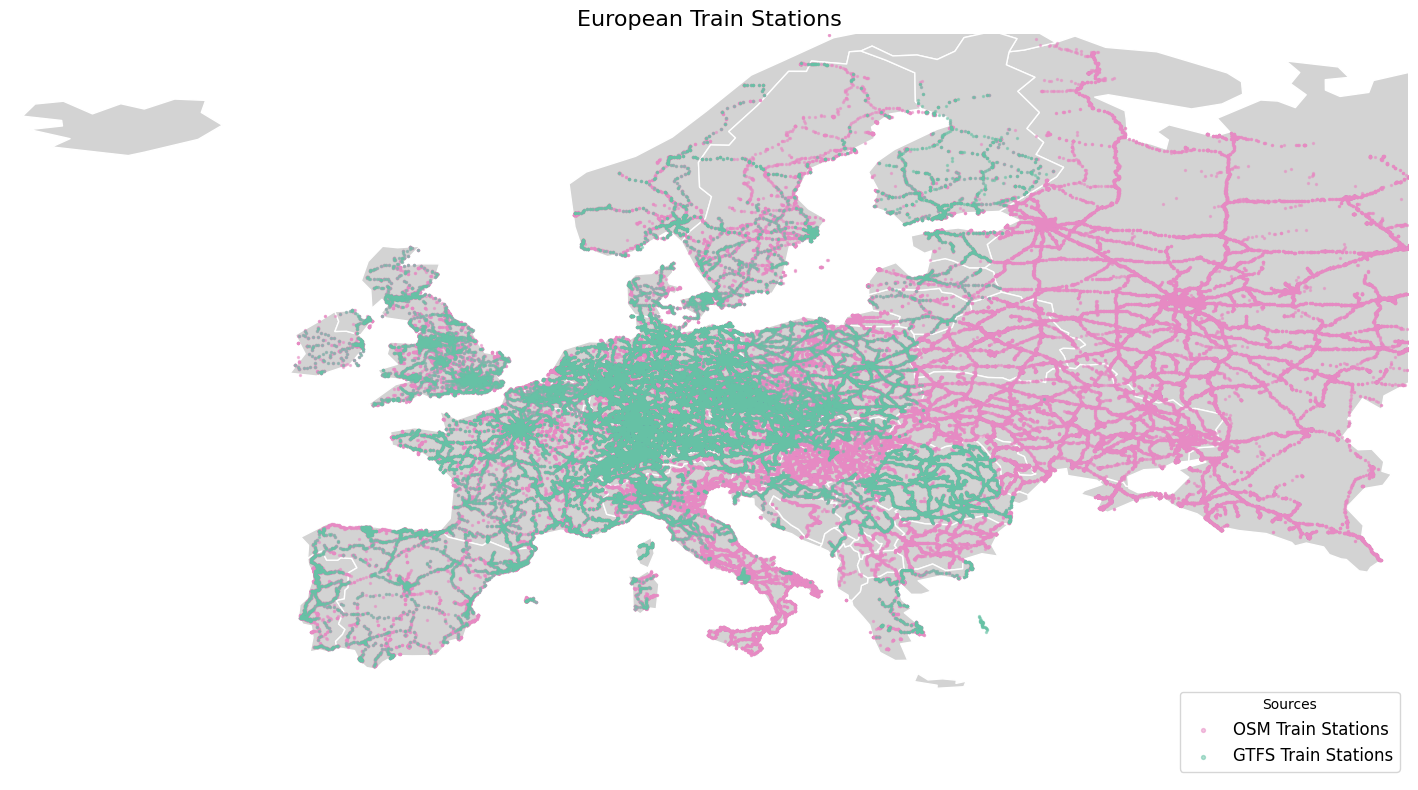

In [30]:
osm_train_stations = pd.read_csv("osm_train_stations.csv")
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))  # Increase the width of the figure
divider = make_axes_locatable(ax)
ax = europe.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot OSM train stations
osm_train_stations['geometry'] = osm_train_stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
# ignore non-european countries
osm_train_stations = osm_train_stations[osm_train_stations['country'].isin(europe['ISO_A2'].tolist() + ['FR', 'NO'])]
osm_train_stations = gpd.GeoDataFrame(osm_train_stations, geometry='geometry')
osm_train_stations.plot(ax=ax, color=sns.color_palette("Set2")[3], markersize=2, label='OSM Train Stations', alpha=0.5)

# Plot GTFS train stations (all_locations is a set of tuples)
gtfs_train_stations = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in all_locations])
gtfs_train_stations.plot(ax=ax, color=sns.color_palette("Set2")[0], markersize=2, label='GTFS Train Stations', alpha=0.5)

# Enhance the plot
ax.set_title("European Train Stations", fontsize=16)
ax.legend(title="Sources", fontsize=12, loc='lower right', markerscale=2)  # Move the legend outside the plot and increase the marker size
ax.set_xlim([-25, 50])  # Approximate bounds for Europe
ax.set_ylim([30, 70])
ax.axis('off')

plt.tight_layout()
plt.savefig(f'figures/{date.today()}_train_stations_europe.png', dpi=300)
plt.show()

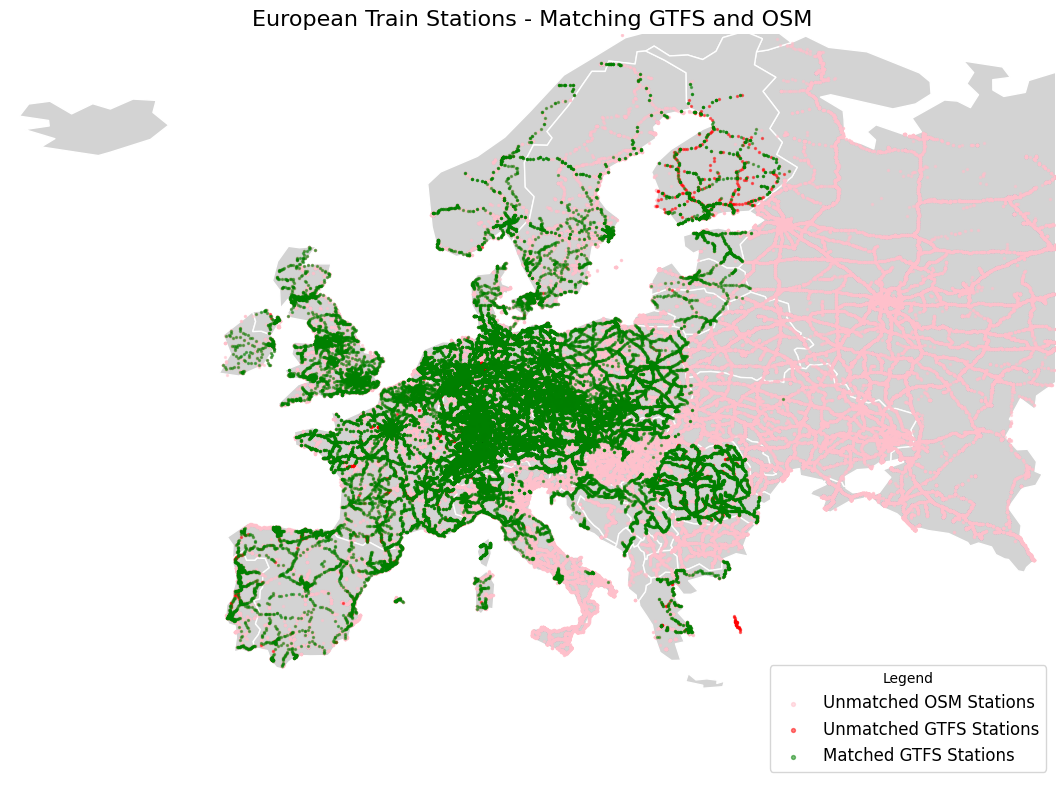

In [33]:
from scipy.spatial import cKDTree
import numpy as np

# Convert coordinates from degrees to radians
all_locations_coords = np.radians(np.array([(lon, lat) for lat, lon in all_locations]))
osm_coords = np.radians(osm_train_stations[['longitude', 'latitude']].to_numpy())

# Build cKDTree for OSM train stations
osm_tree = cKDTree(osm_coords)

# Query the nearest neighbors for all_locations within 200 meters (0.2 km)
# Earth's radius is approximately 6371 km, so 200 meters is 0.2 / 6371 radians
distance_upper_bound = 0.5 / 6371
distances, indices = osm_tree.query(all_locations_coords, distance_upper_bound=distance_upper_bound)

# Create masks for matched and unmatched stations
matched_mask = distances != np.inf
unmatched_mask = ~matched_mask

# Mark OSM stations that are matched
osm_matched_mask = np.zeros(len(osm_coords), dtype=bool)
osm_matched_mask[indices[matched_mask]] = True
osm_unmatched_mask = ~osm_matched_mask

# Plotting
fig, ax = plt.subplots(figsize=(20, 8))
divider = make_axes_locatable(ax)
ax = europe.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot unmatched OSM stations in pink
unmatched_osm = np.degrees(osm_coords[osm_unmatched_mask])
ax.scatter(unmatched_osm[:, 0], unmatched_osm[:, 1], color='pink', s=2, label='Unmatched OSM Stations', alpha=0.5)
# Plot unmatched GTFS stations in red
unmatched_gtfs = np.degrees(all_locations_coords[unmatched_mask])
ax.scatter(unmatched_gtfs[:, 0], unmatched_gtfs[:, 1], color='red', s=2, label='Unmatched GTFS Stations', alpha=0.5)

# Plot matched GTFS stations in green
matched_gtfs = np.degrees(all_locations_coords[matched_mask])
ax.scatter(matched_gtfs[:, 0], matched_gtfs[:, 1], color='green', s=2, label='Matched GTFS Stations', alpha=0.5)


# Enhance the plot
ax.set_title("European Train Stations - Matching GTFS and OSM", fontsize=16)
ax.legend(title="Legend", fontsize=12, loc='lower right', markerscale=2)
ax.set_xlim([-25, 50])  # Approximate bounds for Europe
ax.set_ylim([30, 70])
ax.axis('off')

plt.tight_layout()
plt.savefig(f'figures/{date.today()}_train_stations_matching.png', dpi=300)
plt.show()